In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [3]:
vix = yf.download("^VIX", start="1990-01-01", end="2025-10-31")
vix.to_csv("vix_data.csv")

C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\3424056596.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="1990-01-01", end="2025-10-31")
[*********************100%***********************]  1 of 1 completed


In [5]:
# Load data, skipping the first 3 rows (headers and "Date" in row 2)
vix = pd.read_csv("vix_data.csv", skiprows=3, header=None)

# Assign correct column names
vix.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

# Select only the required columns
vix = vix[["Date", "Close"]].copy()

# Convert dates and sort
vix["Date"] = pd.to_datetime(vix["Date"], errors="coerce")
vix = vix.dropna(subset=["Date"])
vix = vix.sort_values("Date").reset_index(drop=True)

# Save cleaned file
vix.to_csv("vix_clean.csv", index=False)

In [7]:
vix.head()

,Date,Close
0,1990-01-02,17.240000
1,1990-01-03,18.190001
2,1990-01-04,19.219999
3,1990-01-05,20.110001
4,1990-01-08,20.260000


In [9]:
# Load S&P 500 data
sp500 = pd.read_csv("sap500.csv")

# Ensure the date column is in datetime format
sp500['Date'] = pd.to_datetime(sp500['Date'], errors='coerce')

# Remove rows with missing dates
sp500 = sp500.dropna(subset=['Date'])

# Filter period 1990-01-01 – 2025-10-30
mask = (sp500['Date'] >= "1990-01-01") & (sp500['Date'] <= "2025-10-30")
sp500 = sp500.loc[mask]

# Keep only Date and Close columns
sp500 = sp500[['Date', 'Close']].copy()

# Sort chronologically
sp500 = sp500.sort_values('Date').reset_index(drop=True)

# Save cleaned file
sp500.to_csv("sp500_clean.csv", index=False)

In [11]:
sp500.head()

,Date,Close
0,1990-01-02,359.690002
1,1990-01-03,358.760010
2,1990-01-04,355.670013
3,1990-01-05,352.200012
4,1990-01-08,353.790009


In [13]:
# Rename VIX Close column to avoid conflict
vix = vix.rename(columns={'Close': 'VIX_Close'})

# Merge tables on 'Date' (left join: all S&P 500 dates)
df = pd.merge(sp500, vix, on='Date', how='left')
df.head()

,Date,Close,VIX_Close
0,1990-01-02,359.690002,17.240000
1,1990-01-03,358.760010,18.190001
2,1990-01-04,355.670013,19.219999
3,1990-01-05,352.200012,20.110001
4,1990-01-08,353.790009,20.260000


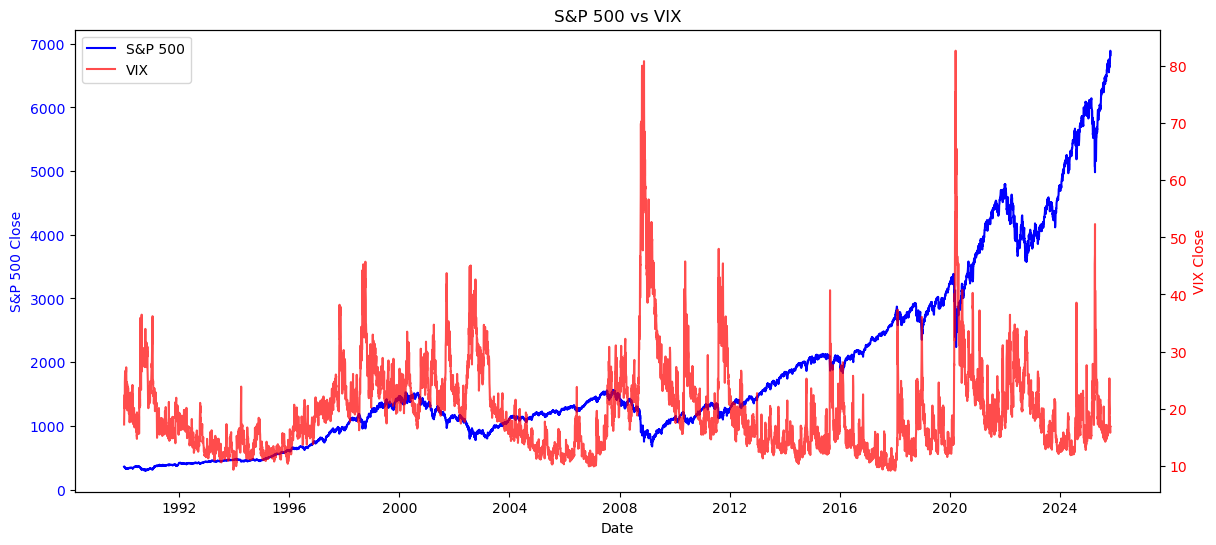

In [15]:
plt.figure(figsize=(14,6))

# Primary axis – S&P 500
ax1 = plt.gca()
ax1.plot(df['Date'], df['Close'], label='S&P 500', color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("S&P 500 Close", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis – VIX
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['VIX_Close'], label='VIX', color='red', alpha=0.7)
ax2.set_ylabel("VIX Close", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legends – combined for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("S&P 500 vs VIX")
plt.show()

In [17]:
# Load full S&P 500 data
sp500_full = pd.read_csv("sap500.csv")
sp500_full['Date'] = pd.to_datetime(sp500_full['Date'], errors='coerce')
sp500_full = sp500_full.dropna(subset=['Date'])
sp500_full = sp500_full.sort_values('Date').reset_index(drop=True)

# Calculate 125-day moving average on full dataset
sp500_full['SMA_125'] = sp500_full['Close'].rolling(window=125).mean()

# Filter period 1990-01-01 → 2025-10-30
mask = (sp500_full['Date'] >= "1990-01-01") & (sp500_full['Date'] <= "2025-10-30")
sp500_filtered = sp500_full.loc[mask, ['Date', 'SMA_125']].copy()

# Merge SMA_125 with df (which already contains S&P Close and VIX)
df = pd.merge(df, sp500_filtered, on='Date', how='left')

In [19]:
df.head()

,Date,Close,VIX_Close,SMA_125
0,1990-01-02,359.690002,17.240000,344.28560
1,1990-01-03,358.760010,18.190001,344.58328
2,1990-01-04,355.670013,19.219999,344.82936
3,1990-01-05,352.200012,20.110001,345.03040
4,1990-01-08,353.790009,20.260000,345.23048


In [21]:
# Add column with daily VIX changes
df['VIX_Change'] = df['VIX_Close'].diff()
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change
0,1990-01-02,359.690002,17.240000,344.28560,NaN
1,1990-01-03,358.760010,18.190001,344.58328,0.950001
2,1990-01-04,355.670013,19.219999,344.82936,1.029999
3,1990-01-05,352.200012,20.110001,345.03040,0.890001
4,1990-01-08,353.790009,20.260000,345.23048,0.150000


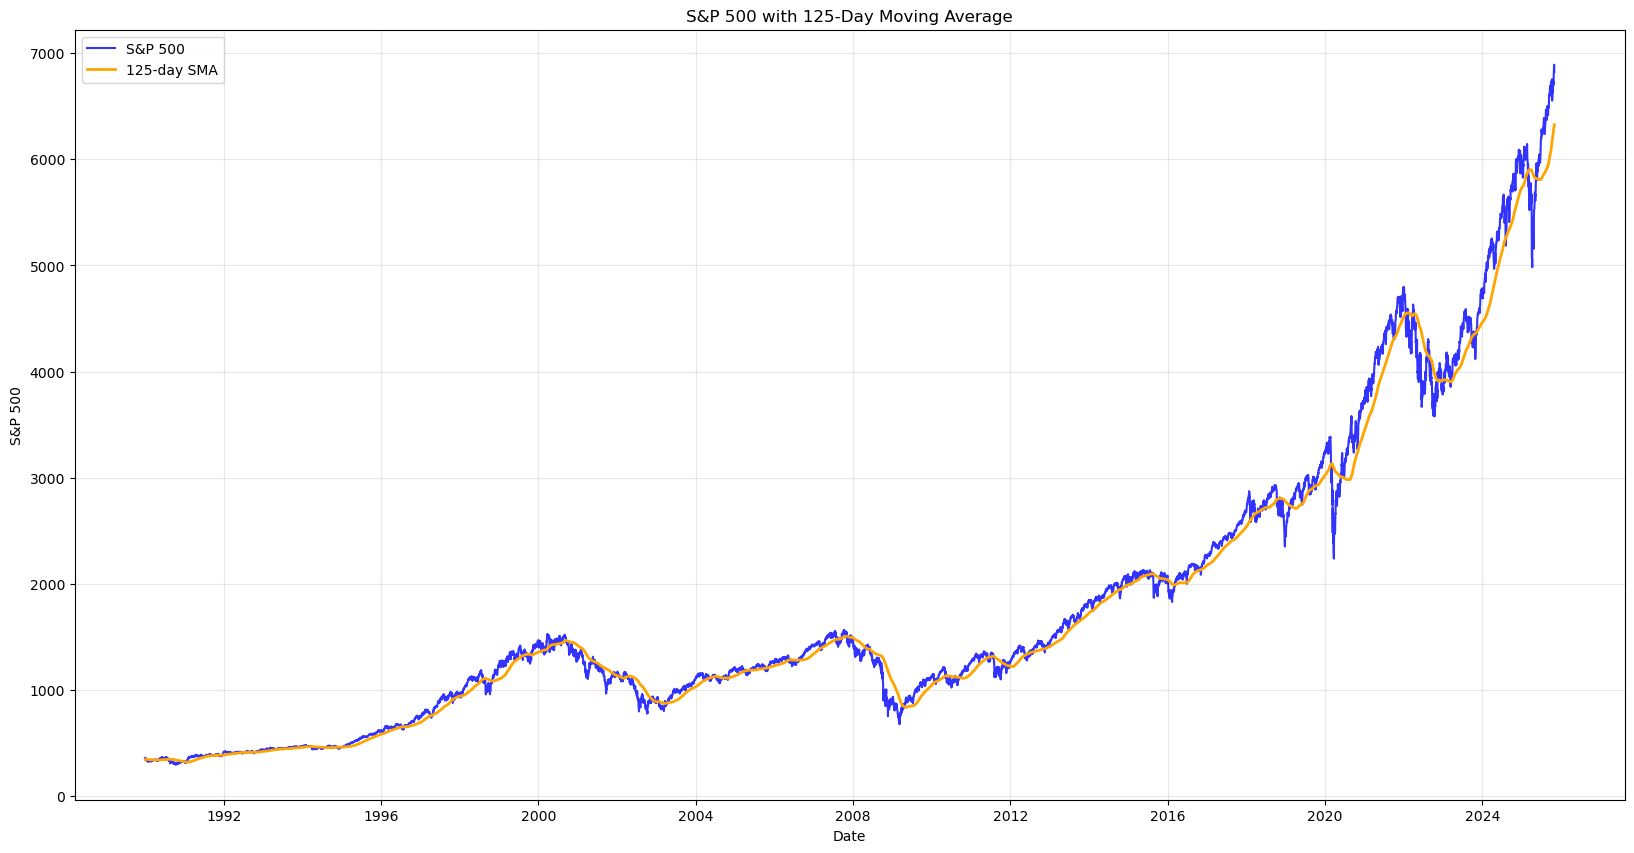

In [23]:
plt.figure(figsize=(20,10))

# Plot S&P 500 Close
plt.plot(df['Date'], df['Close'], label='S&P 500', color='blue', alpha=0.8)

# Plot 125-day moving average
plt.plot(df['Date'], df['SMA_125'], label='125-day SMA', color='orange', linewidth=2)

# Title and axis labels
plt.title("S&P 500 with 125-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("S&P 500")

# Legend
plt.legend(loc='upper left')

# Grid
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# Distance from SMA_125
df['Distance_from_SMA'] = df['Close'] - df['SMA_125']
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change,Distance_from_SMA
0,1990-01-02,359.690002,17.240000,344.28560,NaN,15.404403
1,1990-01-03,358.760010,18.190001,344.58328,0.950001,14.176730
2,1990-01-04,355.670013,19.219999,344.82936,1.029999,10.840653
3,1990-01-05,352.200012,20.110001,345.03040,0.890001,7.169612
4,1990-01-08,353.790009,20.260000,345.23048,0.150000,8.559528


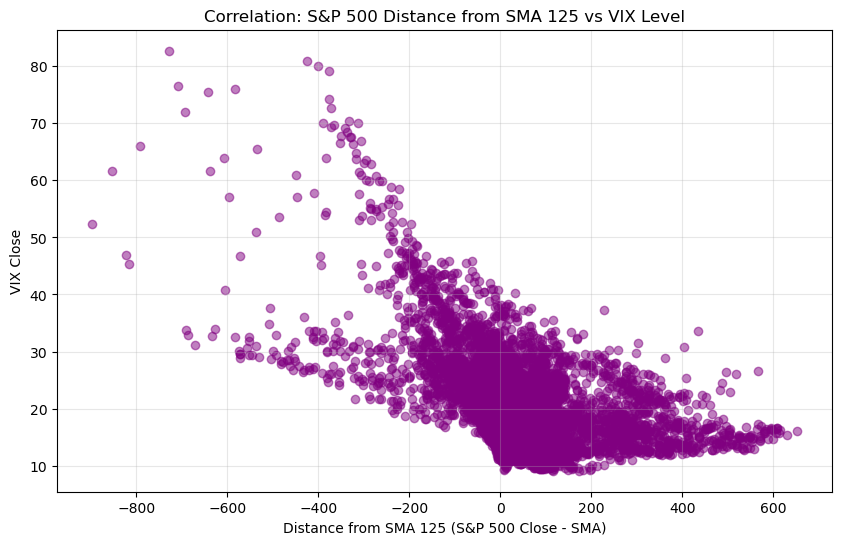

In [27]:
plt.figure(figsize=(10,6))

# Scatter plot: Distance_from_SMA vs VIX
plt.scatter(df['Distance_from_SMA'], df['VIX_Close'], alpha=0.5, color='purple')
plt.title("Correlation: S&P 500 Distance from SMA 125 vs VIX Level")
plt.xlabel("Distance from SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("VIX Close")
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
df['VIX_Close'].mean()

19.464452079181196

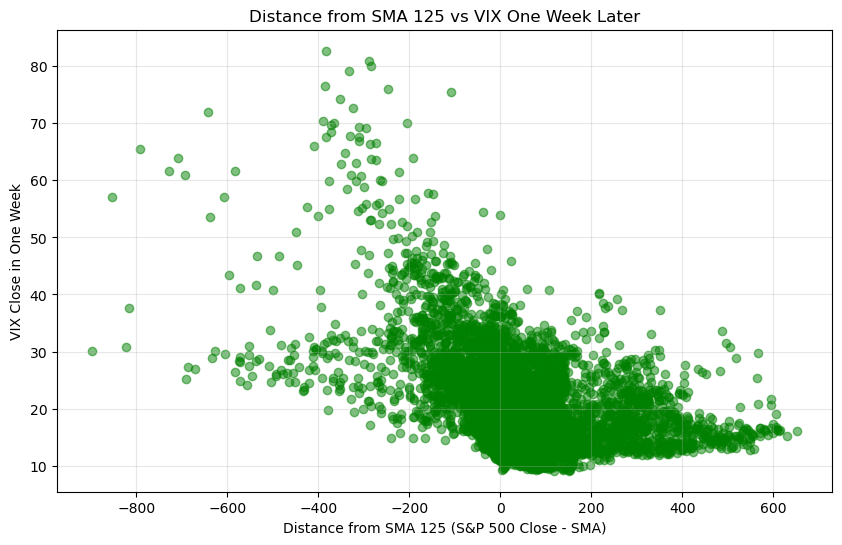

In [31]:
# Create column VIX_7_days_later (5 trading days)
df['VIX_7_days_later'] = df['VIX_Close'].shift(-5)

# Remove last 7 days with NaN
df_shifted = df.dropna(subset=['VIX_7_days_later'])

# Scatter plot: Distance_from_SMA vs VIX one week later
plt.figure(figsize=(10,6))
plt.scatter(df_shifted['Distance_from_SMA'], df_shifted['VIX_7_days_later'],
            alpha=0.5, color='green')
plt.title("Distance from SMA 125 vs VIX One Week Later")
plt.xlabel("Distance from SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("VIX Close in One Week")
plt.grid(True, alpha=0.3)
plt.show()

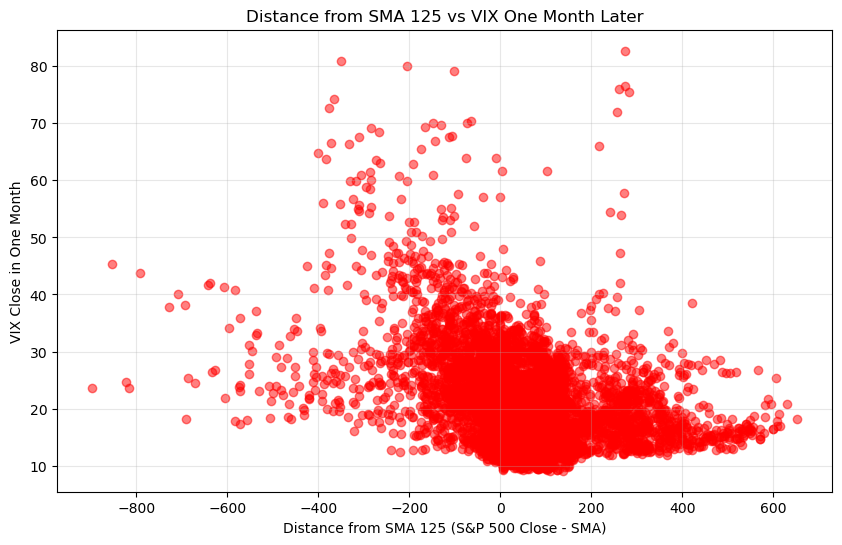

In [33]:
# Create column VIX_30_days_later (4 weeks = 20 trading days)
df['VIX_30_days_later'] = df['VIX_Close'].shift(-20)

# Remove last 4 weeks with NaN
df_shifted_30 = df.dropna(subset=['VIX_30_days_later'])

# Scatter plot: Distance_from_SMA vs VIX one month later
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_30['Distance_from_SMA'], df_shifted_30['VIX_30_days_later'],
            alpha=0.5, color='red')
plt.title("Distance from SMA 125 vs VIX One Month Later")
plt.xlabel("Distance from SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("VIX Close in One Month")
plt.grid(True, alpha=0.3)
plt.show()

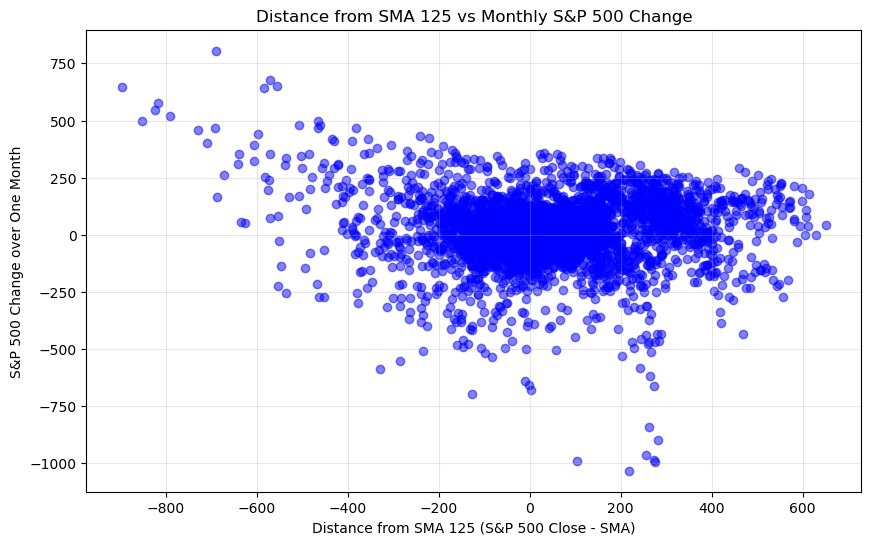

In [35]:
# Create column with 30-day S&P 500 change
df['SP500_change_30d'] = df['Close'].shift(-20) - df['Close']

# Remove last 20 days with NaN
df_shifted_sp500 = df.dropna(subset=['SP500_change_30d'])

# Scatter plot: Distance_from_SMA vs monthly S&P 500 change
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_sp500['Distance_from_SMA'], df_shifted_sp500['SP500_change_30d'],
            alpha=0.5, color='blue')
plt.title("Distance from SMA 125 vs Monthly S&P 500 Change")
plt.xlabel("Distance from SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("S&P 500 Change over One Month")
plt.grid(True, alpha=0.3)
plt.show()

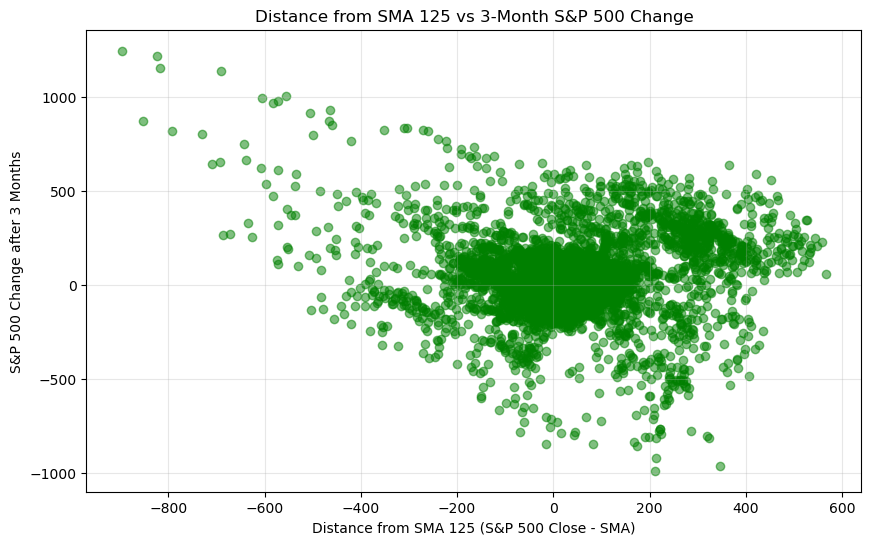

In [37]:
# Create column with 90-day S&P 500 change (3x 4 weeks)
df['SP500_change_90d'] = df['Close'].shift(-60) - df['Close']

# Remove last 3 months with NaN
df_shifted_sp500_90 = df.dropna(subset=['SP500_change_90d'])

# Scatter plot: Distance_from_SMA vs 3-month S&P 500 change
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_sp500_90['Distance_from_SMA'], df_shifted_sp500_90['SP500_change_90d'],
            alpha=0.5, color='green')
plt.title("Distance from SMA 125 vs 3-Month S&P 500 Change")
plt.xlabel("Distance from SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("S&P 500 Change after 3 Months")
plt.grid(True, alpha=0.3)
plt.show()

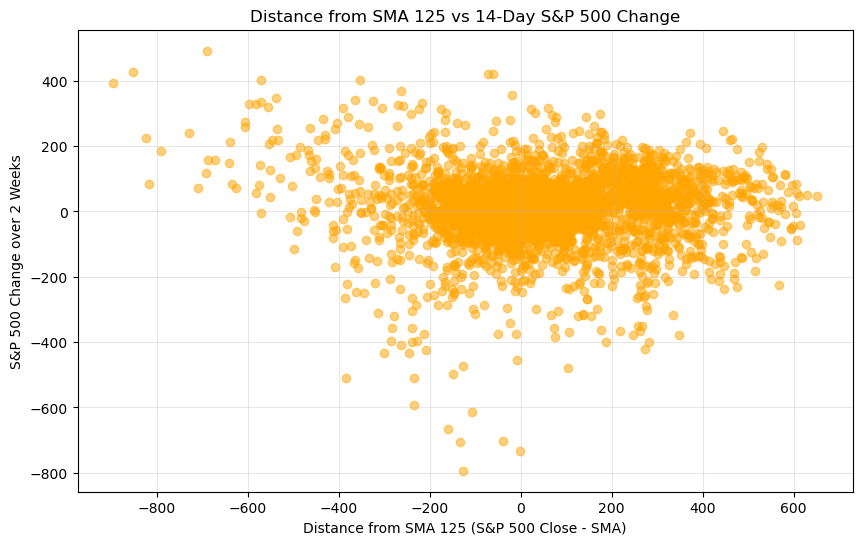

In [39]:
# Create column with 14-day S&P 500 change
df['SP500_change_14d'] = df['Close'].shift(-10) - df['Close']

# Remove last days with NaN
df_shifted_sp500_14 = df.dropna(subset=['SP500_change_14d'])

# Scatter plot: Distance_from_SMA vs 14-day S&P 500 change
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_sp500_14['Distance_from_SMA'], df_shifted_sp500_14['SP500_change_14d'],
            alpha=0.5, color='orange')
plt.title("Distance from SMA 125 vs 14-Day S&P 500 Change")
plt.xlabel("Distance from SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("S&P 500 Change over 2 Weeks")
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
# Remove rows with missing SP500_change_30d
df_shifted_sp500 = df.dropna(subset=['SP500_change_30d'])

# Filter only negative distances from SMA
df_negative = df_shifted_sp500[df_shifted_sp500['Distance_from_SMA'] < 0]

# Sort ascending by Distance_from_SMA
df_negative_sorted = df_negative.sort_values('Distance_from_SMA')

# Get all unique negative values in ascending order
negative_values = np.sort(df_negative_sorted['Distance_from_SMA'].unique())

threshold = None

# Iterate from least negative towards most negative
for dist in reversed(negative_values):  # from largest negative toward -inf
    subset = df_negative_sorted[df_negative_sorted['Distance_from_SMA'] <= dist]
    if (subset['SP500_change_30d'] > 0).all():
        threshold = dist
        break

print(f"Largest negative Distance_from_SMA where all more negative values give positive S&P 500 change after 30 days: {threshold:.2f}")

Largest negative Distance_from_SMA where all more negative values give positive S&P 500 change after 30 days: -556.46


In [43]:
# Top 200 largest distances from SMA 125
top200_distance = df.sort_values(by='Distance_from_SMA', ascending=False).head(200)

print("Top 200 Distance_from_SMA readings:")
print(top200_distance[['Date', 'Close', 'Distance_from_SMA', 'SP500_change_90d']])

Top 200 Distance_from_SMA readings:
           Date        Close  Distance_from_SMA  SP500_change_90d
8996 2025-09-22  6693.750000         651.790016               NaN
8995 2025-09-19  6664.359863         629.809320               NaN
9003 2025-10-01  6711.200195         613.838687               NaN
8991 2025-09-15  6615.279785         611.793477               NaN
8997 2025-09-23  6656.919922         607.917777               NaN
...         ...          ...                ...               ...
7889 2021-04-26  4187.620117         388.182514        171.069824
7888 2021-04-23  4180.169922         386.510160        142.890137
8453 2023-07-24  4554.640137         385.483180       -181.439941
8801 2024-12-09  6052.850098         384.623781       -438.290039
7879 2021-04-12  4127.990234         383.513270        230.139648

[200 rows x 4 columns]


In [45]:
# Filter observations with Distance_from_SMA >= 570
df_positive_high = df_shifted_sp500[df_shifted_sp500['Distance_from_SMA'] >= 570]

# Maximum drop after 30 days (minimum SP500_change_30d)
max_drop_30d = df_positive_high['SP500_change_30d'].min()

print(f"Maximum S&P 500 drop after 30 days for Distance_from_SMA >= 570: {max_drop_30d:.2f}")

Maximum S&P 500 drop after 30 days for Distance_from_SMA >= 570: -31.78


In [47]:
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change,Distance_from_SMA,VIX_7_days_later,VIX_30_days_later,SP500_change_30d,SP500_change_90d,SP500_change_14d
0,1990-01-02,359.690002,17.240000,344.28560,NaN,15.404403,22.200001,27.250000,-36.709991,-17.690002,-18.940002
1,1990-01-03,358.760010,18.190001,344.58328,0.950001,14.176730,22.440001,25.360001,-29.680023,-17.970001,-21.360016
2,1990-01-04,355.670013,19.219999,344.82936,1.029999,10.840653,20.049999,24.870001,-26.880005,-15.730011,-17.480011
3,1990-01-05,352.200012,20.110001,345.03040,0.890001,7.169612,24.639999,24.320000,-21.279999,-13.500000,-13.050018
4,1990-01-08,353.790009,20.260000,345.23048,0.150000,8.559528,26.340000,24.540001,-21.940002,-10.149994,-23.410004


In [49]:
# Remove rows with missing SP500_change_14d
df_bins_14d = df.dropna(subset=['SP500_change_14d'])

# Define simplified bins for Distance_from_SMA
bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
labels = ["< -400", "-400 to -200", "-200 to 0", "0 to 200", "200 to 400", "> 400"]

# Assign each row to a bin
df_bins_14d['Distance_bin'] = pd.cut(df_bins_14d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)

# Count up (>0) and down (<=0) cases for each bin
summary_table_14d = df_bins_14d.groupby('Distance_bin')['SP500_change_14d'].agg(
    Up=lambda x: (x > 0).sum(),
    Down=lambda x: (x <= 0).sum()
)

# Display the table
print("S&P 500 change over 14 days by Distance_from_SMA:")
print(summary_table_14d)

S&P 500 change over 14 days by Distance_from_SMA:
                Up  Down
Distance_bin            
< -400          59    13
-400 to -200   117    89
-200 to 0     1317   885
0 to 200      3450  2298
200 to 400     407   220
> 400          103    57


C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\832740154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bins_14d['Distance_bin'] = pd.cut(df_bins_14d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\832740154.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table_14d = df_bins_14d.groupby('Distance_bin')['SP500_change_14d'].agg(


In [51]:
# Remove rows with missing SP500_change_30d
df_bins = df.dropna(subset=['SP500_change_30d'])

# Define simplified bins
bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
labels = ["< -400", "-400 to -200", "-200 to 0", "0 to 200", "200 to 400", "> 400"]

# Assign each row to a bin
df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)

# Count up (>0) and down (<=0) cases for each bin
summary_table = df_bins.groupby('Distance_bin')['SP500_change_30d'].agg(
    Up=lambda x: (x > 0).sum(),
    Down=lambda x: (x <= 0).sum()
)

# Display the table
print(summary_table)

                Up  Down
Distance_bin            
< -400          62    10
-400 to -200   114    92
-200 to 0     1352   850
0 to 200      3658  2090
200 to 400     448   178
> 400           98    53


C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\2051619719.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\2051619719.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df_bins.groupby('Distance_bin')['SP500_change_30d'].agg(


In [53]:
# Remove rows with missing SP500_change_90d
df_bins_90d = df.dropna(subset=['SP500_change_90d'])

# Define bins (same as before)
bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
labels = ["< -400", "-400 to -200", "-200 to 0", "0 to 200", "200 to 400", "> 400"]

# Assign each row to a bin based on Distance_from_SMA
df_bins_90d['Distance_bin'] = pd.cut(df_bins_90d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)

# Count up (>0) and down (<=0) cases over 90 days for each bin
summary_table_90d = df_bins_90d.groupby('Distance_bin')['SP500_change_90d'].agg(
    Up=lambda x: (x > 0).sum(),
    Down=lambda x: (x <= 0).sum()
)

# Display the table
print("📊 S&P 500 change over 90 days by Distance_from_SMA:")
print(summary_table_90d)

📊 S&P 500 change over 90 days by Distance_from_SMA:
                Up  Down
Distance_bin            
< -400          60    12
-400 to -200   107    99
-200 to 0     1463   739
0 to 200      4095  1653
200 to 400     446   180
> 400          102     9


C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\512082214.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bins_90d['Distance_bin'] = pd.cut(df_bins_90d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\512082214.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table_90d = df_bins_90d.groupby('Distance_bin')['SP500_change_90d'].agg(


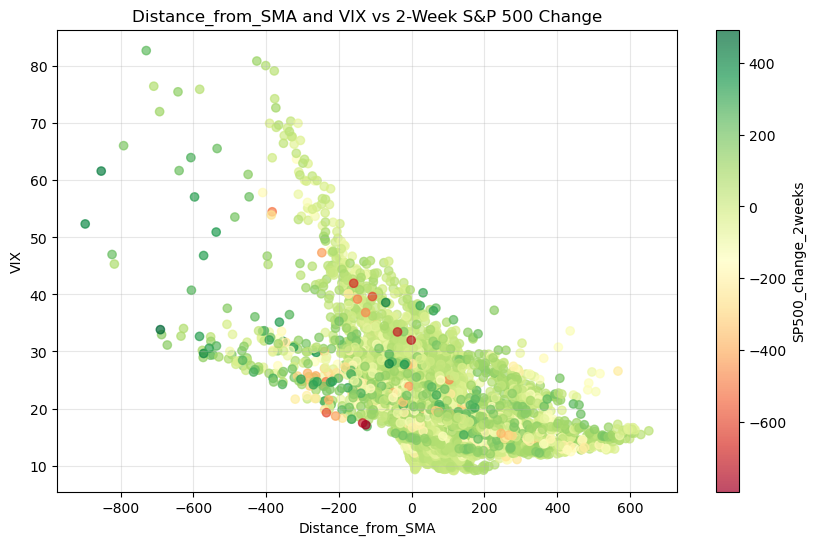

In [55]:
# Remove missing values
df_plot_14d = df.dropna(subset=['SP500_change_14d', 'VIX_Close'])

# Scatter plot
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot_14d['Distance_from_SMA'],
    df_plot_14d['VIX_Close'],
    c=df_plot_14d['SP500_change_14d'],  # color by 14-day S&P 500 change
    cmap='RdYlGn',                      # green = up, red = down
    alpha=0.7
)

# Colorbar
plt.colorbar(scatter, label='SP500_change_2weeks')

# Axis labels and title
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA and VIX vs 2-Week S&P 500 Change")

plt.grid(True, alpha=0.3)
plt.show()

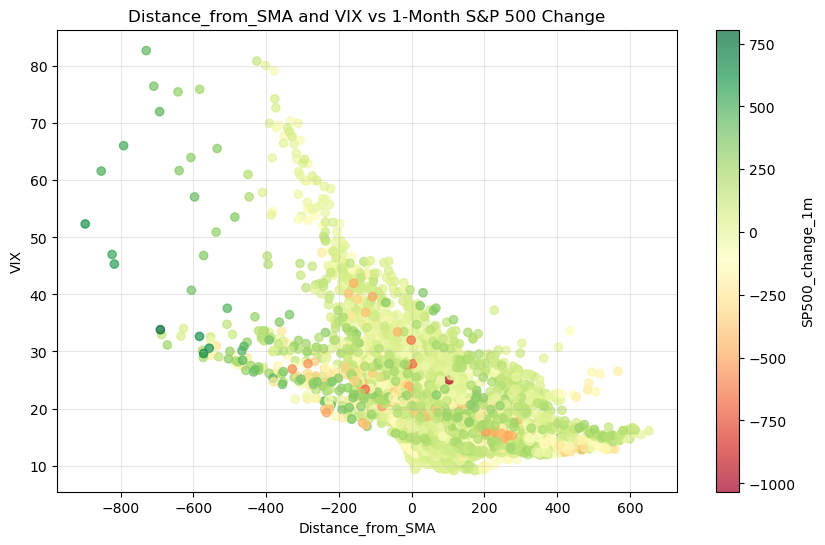

In [57]:
# Remove missing values
df_plot = df.dropna(subset=['SP500_change_30d', 'VIX_Close'])

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot['Distance_from_SMA'],
    df_plot['VIX_Close'],
    c=df_plot['SP500_change_30d'],  # color by S&P 500 change
    cmap='RdYlGn',                  # green = up, red = down
    alpha=0.7
)
plt.colorbar(scatter, label='SP500_change_1m')
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA and VIX vs 1-Month S&P 500 Change")
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\3395589131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Distance_bin'] = pd.cut(df_plot['Distance_from_SMA'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\3395589131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['VIX_bin'] = pd.cut(df_plot['VIX_Close'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\3395589131.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

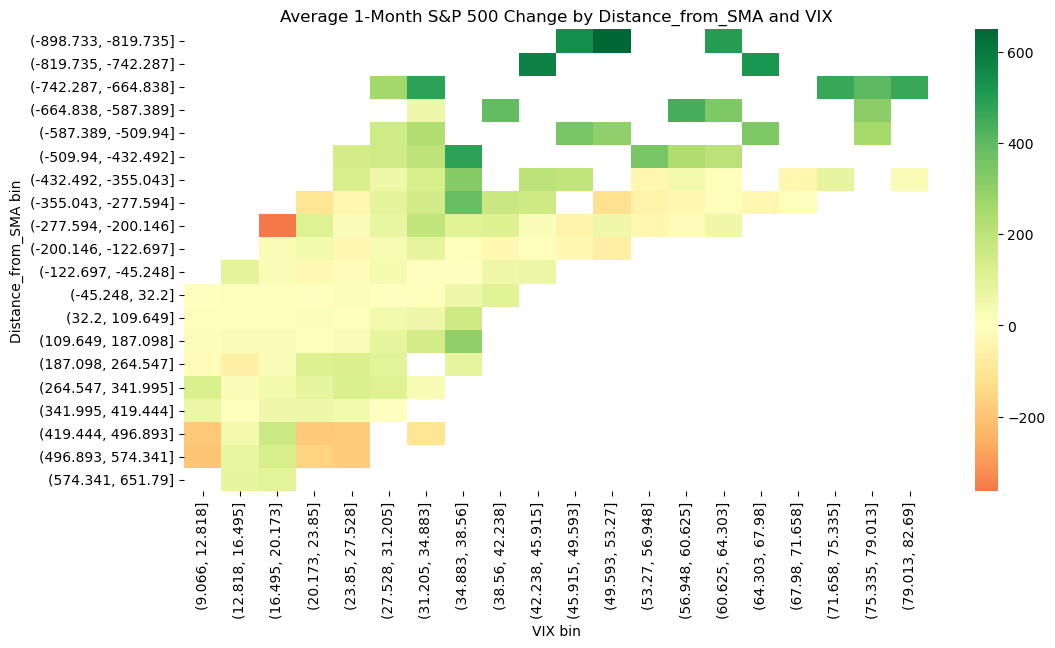

In [59]:
# Create bins
df_plot['Distance_bin'] = pd.cut(df_plot['Distance_from_SMA'], bins=20)
df_plot['VIX_bin'] = pd.cut(df_plot['VIX_Close'], bins=20)

# Group and calculate mean S&P500 change
heatmap_data = df_plot.groupby(['Distance_bin','VIX_bin'])['SP500_change_30d'].mean().unstack()

# Draw heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='RdYlGn', center=0)
plt.title("Average 1-Month S&P 500 Change by Distance_from_SMA and VIX")
plt.xlabel("VIX bin")
plt.ylabel("Distance_from_SMA bin")
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\763286729.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_14d['Distance_bin'] = pd.cut(df_plot_14d['Distance_from_SMA'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\763286729.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_14d['VIX_bin'] = pd.cut(df_plot_14d['VIX_Close'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\763286729.py:9: FutureWarning: The default of observed=False is deprecated and will be changed

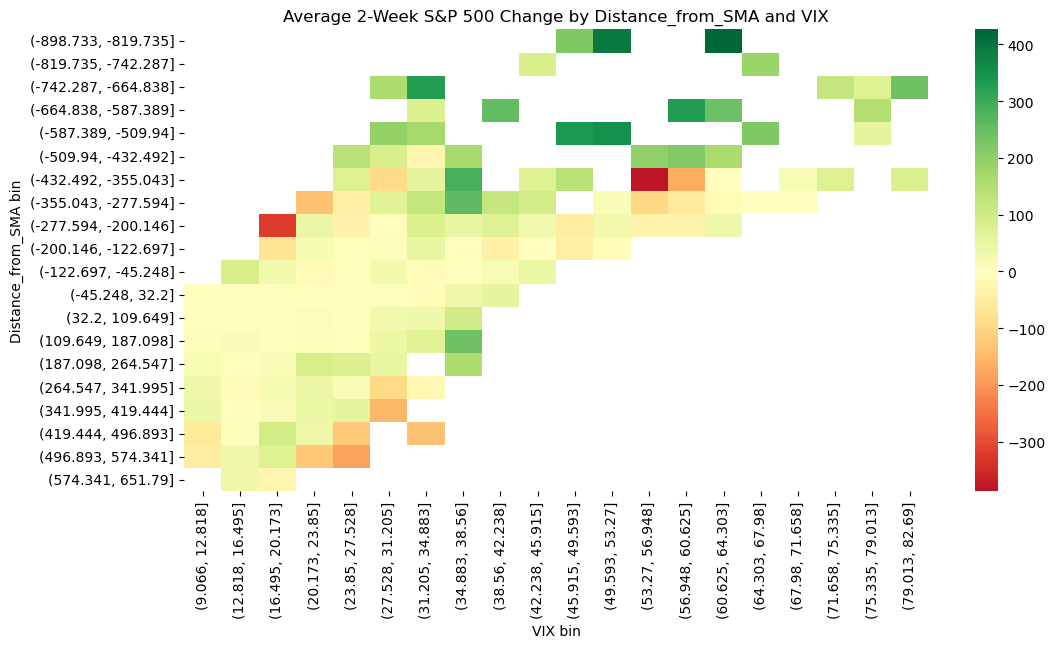

In [61]:
# Remove missing values
df_plot_14d = df.dropna(subset=['SP500_change_14d', 'VIX_Close'])

# Create bins
df_plot_14d['Distance_bin'] = pd.cut(df_plot_14d['Distance_from_SMA'], bins=20)
df_plot_14d['VIX_bin'] = pd.cut(df_plot_14d['VIX_Close'], bins=20)

# Group and calculate mean 14-day S&P500 change
heatmap_data_14d = df_plot_14d.groupby(['Distance_bin','VIX_bin'])['SP500_change_14d'].mean().unstack()

# Draw heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data_14d, cmap='RdYlGn', center=0)
plt.title("Average 2-Week S&P 500 Change by Distance_from_SMA and VIX")
plt.xlabel("VIX bin")
plt.ylabel("Distance_from_SMA bin")
plt.show()

In [63]:
# Filter cases where VIX < 10 and SP500_change_30d is available
vix_low = df.dropna(subset=['VIX_Close', 'SP500_change_30d'])
vix_low = vix_low[vix_low['VIX_Close'] < 10]

# Count S&P 500 up and down cases after 30 days
up_count = (vix_low['SP500_change_30d'] > 0).sum()
down_count = (vix_low['SP500_change_30d'] < 0).sum()
total = len(vix_low)

print(f"Number of cases with VIX < 10: {total}")
print(f"- S&P 500 up after 30 days: {up_count} ({up_count/total*100:.2f}%)")
print(f"- S&P 500 down after 30 days: {down_count} ({down_count/total*100:.2f}%)")

Number of cases with VIX < 10: 68
- S&P 500 up after 30 days: 51 (75.00%)
- S&P 500 down after 30 days: 17 (25.00%)


In [65]:
# Filter cases where VIX < 10 and SP500_change_14d is available
vix_low_14d = df.dropna(subset=['VIX_Close', 'SP500_change_14d'])
vix_low_14d = vix_low_14d[vix_low_14d['VIX_Close'] < 10]

# Count S&P 500 up and down cases after 14 days
up_count = (vix_low_14d['SP500_change_14d'] > 0).sum()
down_count = (vix_low_14d['SP500_change_14d'] < 0).sum()
total = len(vix_low_14d)

print(f"Number of cases with VIX < 10: {total}")
print(f"- S&P 500 up after 14 days: {up_count} ({up_count/total*100:.2f}%)")
print(f"- S&P 500 down after 14 days: {down_count} ({down_count/total*100:.2f}%)")

Number of cases with VIX < 10: 68
- S&P 500 up after 14 days: 56 (82.35%)
- S&P 500 down after 14 days: 12 (17.65%)


In [67]:
# Maximum drop after 14 days when VIX < 10
vix_low_14 = df.dropna(subset=['VIX_Close', 'SP500_change_14d'])
vix_low_14 = vix_low_14[vix_low_14['VIX_Close'] < 10]
max_drop_14 = vix_low_14['SP500_change_14d'].min()
print(f"Maximum S&P 500 drop after 14 days when VIX < 10: {max_drop_14:.2f} points")

Maximum S&P 500 drop after 14 days when VIX < 10: -52.54 points


In [69]:
# Maximum drop after 30 days when VIX < 10
vix_low = df.dropna(subset=['VIX_Close', 'SP500_change_30d'])
vix_low = vix_low[vix_low['VIX_Close'] < 10]
max_drop = vix_low['SP500_change_30d'].min()
print(f"Maximum S&P 500 drop after 30 days when VIX < 10: {max_drop:.2f} points")

Maximum S&P 500 drop after 30 days when VIX < 10: -167.23 points


In [71]:
# S&P 500 after 30 days depending on VIX thresholds
vix_thresholds = [10, 15, 20, 25]
results = []

for thresh in vix_thresholds:
    vix_low = df.dropna(subset=['VIX_Close', 'SP500_change_30d'])
    vix_low = vix_low[vix_low['VIX_Close'] < thresh]
    
    total = len(vix_low)
    up_count = (vix_low['SP500_change_30d'] > 0).sum()
    down_count = (vix_low['SP500_change_30d'] < 0).sum()
    max_drop = vix_low['SP500_change_30d'].min() if total > 0 else None
    
    results.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_days': up_count,
        'Down_days': down_count,
        'Up_%': up_count/total*100 if total > 0 else None,
        'Down_%': down_count/total*100 if total > 0 else None,
        'Max_drop': max_drop
    })

results_df = pd.DataFrame(results)
print(results_df)

   VIX_threshold  Total_days  Up_days  Down_days       Up_%     Down_%  \
0             10          68       51         17  75.000000  25.000000   
1             15        2934     1926       1007  65.644172  34.321745   
2             20        5627     3626       2000  64.439310  35.542918   
3             25        7420     4687       2732  63.167116  36.819407   

      Max_drop  
0  -167.229980  
1  -994.030029  
2 -1032.830078  
3 -1032.830078  


In [73]:
# S&P 500 after 2 weeks depending on VIX and Distance_from_SMA > 400
vix_thresholds = [10, 15, 20, 25]
results_14d = []

for thresh in vix_thresholds:
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_14d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_14d'] > 0).sum()
    down_count = (df_filtered['SP500_change_14d'] < 0).sum()
    max_drop = df_filtered['SP500_change_14d'].min() if total > 0 else None
    
    results_14d.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_days': up_count,
        'Down_days': down_count,
        'Up_%': up_count/total*100 if total > 0 else None,
        'Down_%': down_count/total*100 if total > 0 else None,
        'Max_drop': max_drop
    })

results_df_14d = pd.DataFrame(results_14d)
print(results_df_14d)

   VIX_threshold  Total_days  Up_days  Down_days       Up_%     Down_%  \
0             10           0        0          0        NaN        NaN   
1             15          76       47         29  61.842105  38.157895   
2             20         143       96         47  67.132867  32.867133   
3             25         154      102         52  66.233766  33.766234   

     Max_drop  
0         NaN  
1 -230.760254  
2 -237.109863  
3 -237.109863  


In [75]:
# S&P 500 after 1 month depending on VIX and Distance_from_SMA > 400
vix_thresholds = [10, 15, 20, 25]
results = []

for thresh in vix_thresholds:
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_30d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_30d'] > 0).sum()
    down_count = (df_filtered['SP500_change_30d'] < 0).sum()
    max_drop = df_filtered['SP500_change_30d'].min() if total > 0 else None
    
    results.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_days': up_count,
        'Down_days': down_count,
        'Up_%': up_count/total*100 if total > 0 else None,
        'Down_%': down_count/total*100 if total > 0 else None,
        'Max_drop': max_drop
    })

results_df = pd.DataFrame(results)
print(results_df)

   VIX_threshold  Total_days  Up_days  Down_days       Up_%     Down_%  \
0             10           0        0          0        NaN        NaN   
1             15          76       43         33  56.578947  43.421053   
2             20         137       97         40  70.802920  29.197080   
3             25         146       98         48  67.123288  32.876712   

     Max_drop  
0         NaN  
1 -434.410156  
2 -434.410156  
3 -434.410156  


   VIX_threshold  Total_days       Up_%     Down_%    Max_drop
0             15          76  56.578947  43.421053 -434.410156
1             20         137  70.802920  29.197080 -434.410156


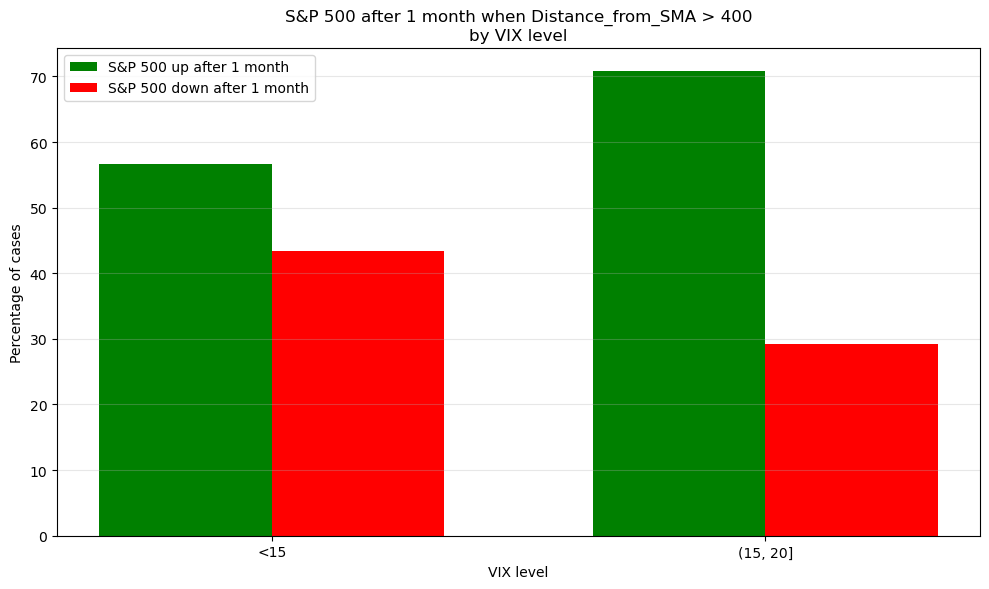

In [77]:
# Plot bar charts for VIX thresholds 15 and 20
vix_thresholds = [15, 20]
results = []

for thresh in vix_thresholds:
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_30d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_30d'] > 0).sum()
    down_count = (df_filtered['SP500_change_30d'] < 0).sum()
    max_drop = df_filtered['SP500_change_30d'].min() if total > 0 else None
    
    results.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_%': up_count/total*100 if total > 0 else 0,
        'Down_%': down_count/total*100 if total > 0 else 0,
        'Max_drop': max_drop
    })

results_df = pd.DataFrame(results)
print(results_df)

x_labels = ["<15", "(15, 20]"]

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(results_df))

plt.bar(x, results_df['Up_%'], width=bar_width, color='green', label='S&P 500 up after 1 month')
plt.bar([p + bar_width for p in x], results_df['Down_%'], width=bar_width, color='red', label='S&P 500 down after 1 month')

plt.xticks([p + bar_width/2 for p in x], x_labels)
plt.xlabel("VIX level")
plt.ylabel("Percentage of cases")
plt.title("S&P 500 after 1 month when Distance_from_SMA > 400\nby VIX level")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

   VIX_threshold  Total_days       Up_%     Down_%    Max_drop
0             15          76  61.842105  38.157895 -230.760254
1             20         143  67.132867  32.867133 -237.109863


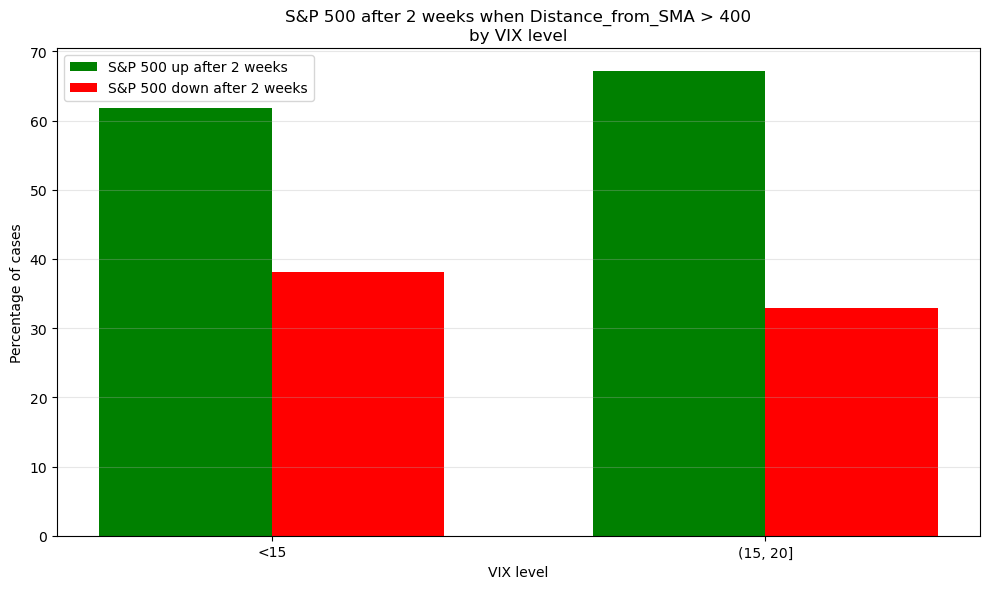

In [79]:
# Plot for S&P 500 after 2 weeks with VIX thresholds 15 and 20
vix_thresholds = [15, 20]
results_14d = []

for thresh in vix_thresholds:
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_14d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_14d'] > 0).sum()
    down_count = (df_filtered['SP500_change_14d'] < 0).sum()
    max_drop = df_filtered['SP500_change_14d'].min() if total > 0 else None
    
    results_14d.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_%': up_count/total*100 if total > 0 else 0,
        'Down_%': down_count/total*100 if total > 0 else 0,
        'Max_drop': max_drop
    })

results_df_14d = pd.DataFrame(results_14d)
print(results_df_14d)

x_labels = ["<15", "(15, 20]"]

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(results_df_14d))

plt.bar(x, results_df_14d['Up_%'], width=bar_width, color='green', label='S&P 500 up after 2 weeks')
plt.bar([p + bar_width for p in x], results_df_14d['Down_%'], width=bar_width, color='red', label='S&P 500 down after 2 weeks')

plt.xticks([p + bar_width/2 for p in x], x_labels)
plt.xlabel("VIX level")
plt.ylabel("Percentage of cases")
plt.title("S&P 500 after 2 weeks when Distance_from_SMA > 400\nby VIX level")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [81]:
df['VIX_change_30d'] = df['VIX_30_days_later'] - df['VIX_Close']

In [83]:
df['VIX_14_days_later'] = df['VIX_Close'].shift(-10)

In [85]:
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change,Distance_from_SMA,VIX_7_days_later,VIX_30_days_later,SP500_change_30d,SP500_change_90d,SP500_change_14d,VIX_change_30d,VIX_14_days_later
0,1990-01-02,359.690002,17.240000,344.28560,NaN,15.404403,22.200001,27.250000,-36.709991,-17.690002,-18.940002,10.010000,24.180000
1,1990-01-03,358.760010,18.190001,344.58328,0.950001,14.176730,22.440001,25.360001,-29.680023,-17.970001,-21.360016,7.170000,24.160000
2,1990-01-04,355.670013,19.219999,344.82936,1.029999,10.840653,20.049999,24.870001,-26.880005,-15.730011,-17.480011,5.650002,24.340000
3,1990-01-05,352.200012,20.110001,345.03040,0.890001,7.169612,24.639999,24.320000,-21.279999,-13.500000,-13.050018,4.209999,22.500000
4,1990-01-08,353.790009,20.260000,345.23048,0.150000,8.559528,26.340000,24.540001,-21.940002,-10.149994,-23.410004,4.280001,26.700001


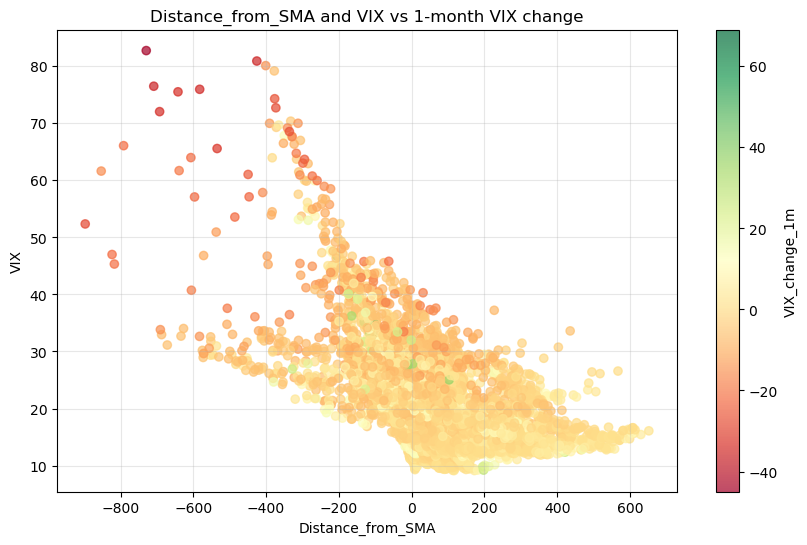

In [87]:
# Drop missing values for plotting
df_plot = df.dropna(subset=['VIX_change_30d', 'VIX_Close'])

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot['Distance_from_SMA'],
    df_plot['VIX_Close'],
    c=df_plot['VIX_change_30d'],  # color by VIX change
    cmap='RdYlGn',                # green = increase, red = decrease
    alpha=0.7
)
plt.colorbar(scatter, label='VIX_change_1m')
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA and VIX vs 1-month VIX change")
plt.grid(True, alpha=0.3)
plt.show()

In [89]:
# Define Distance_from_SMA bins
distance_bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
distance_labels = ["<= -400", "(-400, -200]", "(-200, 0]", "(0, 200]", "(200, 400]", "> 400"]

# Define VIX bins
vix_bins = [0, 10, 15, 20, 25, np.inf]
vix_labels = ["<10", "10–15", "15–20", "20–25", ">25"]

# Copy necessary columns
df_bins = df.dropna(subset=['VIX_Close', 'VIX_change_30d', 'Distance_from_SMA']).copy()

# Assign bins
df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=distance_bins, labels=distance_labels)
df_bins['VIX_bin'] = pd.cut(df_bins['VIX_Close'], bins=vix_bins, labels=vix_labels)

# Group data by Distance and VIX bins
grouped_vix = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(
    Total_obs=('VIX_change_30d', 'count'),
    Up_days=('VIX_change_30d', lambda x: (x > 0).sum()),      
    Down_days=('VIX_change_30d', lambda x: (x < 0).sum()),    
    Up_pct=('VIX_change_30d', lambda x: (x > 0).mean() * 100),
    Down_pct=('VIX_change_30d', lambda x: (x < 0).mean() * 100),
    Avg_VIX_change_30d=('VIX_change_30d', 'mean'),
    Max_VIX_increase_30d=('VIX_change_30d', 'max'),
    Max_VIX_drop_30d=('VIX_change_30d', 'min')
).reset_index()

pd.set_option('display.max_rows', None)
print(grouped_vix)

    Distance_bin VIX_bin  Total_obs  Up_days  Down_days      Up_pct  \
0        <= -400     <10          0      NaN        NaN         NaN   
1        <= -400   10–15          0      NaN        NaN         NaN   
2        <= -400   15–20          0      NaN        NaN         NaN   
3        <= -400   20–25          0      NaN        NaN         NaN   
4        <= -400     >25         72      6.0       66.0    8.333333   
5   (-400, -200]     <10          0      NaN        NaN         NaN   
6   (-400, -200]   10–15          0      NaN        NaN         NaN   
7   (-400, -200]   15–20          4      4.0        0.0  100.000000   
8   (-400, -200]   20–25         31     14.0       17.0   45.161290   
9   (-400, -200]     >25        171     37.0      134.0   21.637427   
10     (-200, 0]     <10          0      NaN        NaN         NaN   
11     (-200, 0]   10–15        178     69.0      109.0   38.764045   
12     (-200, 0]   15–20        440    111.0      328.0   25.227273   
13    

C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\2988827237.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vix = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(


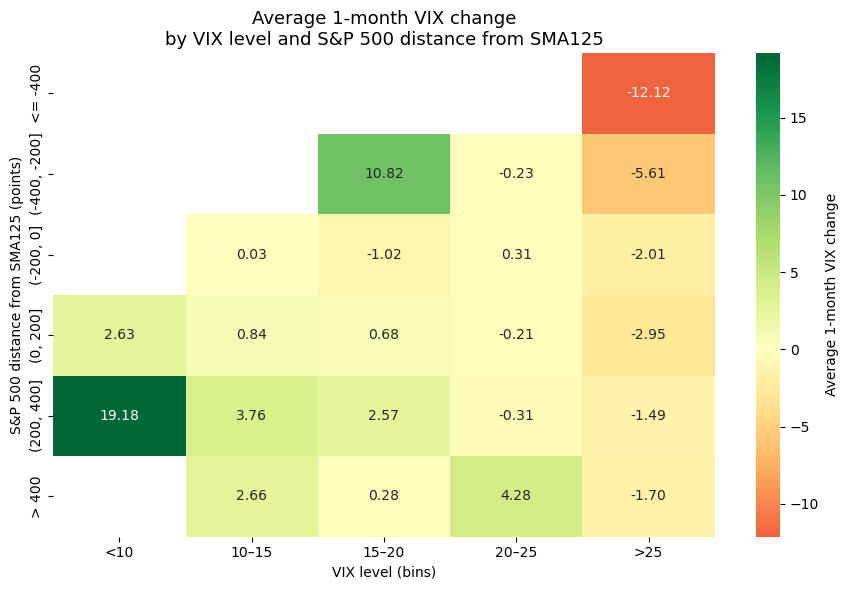

In [91]:
# Pivot for heatmap
heatmap_data = grouped_vix.pivot(
    index='Distance_bin', 
    columns='VIX_bin', 
    values='Avg_VIX_change_30d'
)

plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    cbar_kws={'label': 'Average 1-month VIX change'}
)
plt.title("Average 1-month VIX change\nby VIX level and S&P 500 distance from SMA125", fontsize=13)
plt.xlabel("VIX level (bins)")
plt.ylabel("S&P 500 distance from SMA125 (points)")
plt.tight_layout()
plt.show()

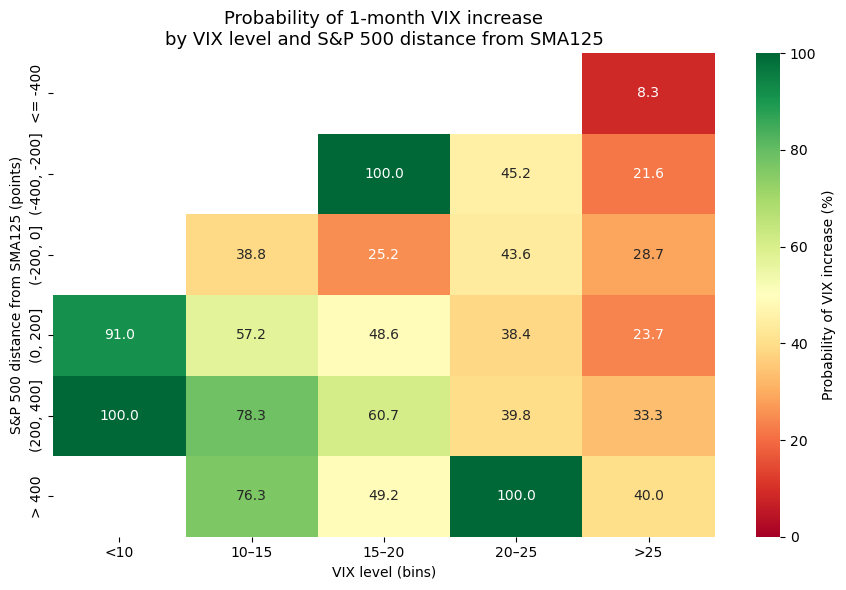

In [93]:
# Pivot for probability of VIX increase
heatmap_up = grouped_vix.pivot(
    index='Distance_bin', 
    columns='VIX_bin', 
    values='Up_pct'
)

plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_up,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    vmin=0, vmax=100,
    cbar_kws={'label': 'Probability of VIX increase (%)'}
)
plt.title("Probability of 1-month VIX increase\nby VIX level and S&P 500 distance from SMA125", fontsize=13)
plt.xlabel("VIX level (bins)")
plt.ylabel("S&P 500 distance from SMA125 (points)")
plt.tight_layout()
plt.show()

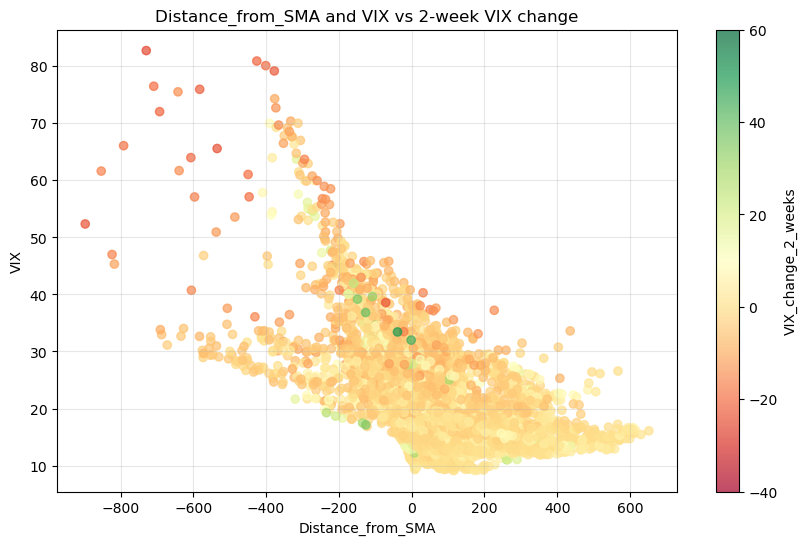

In [95]:
# Compute 14-day VIX change
df['VIX_change_14d'] = df['VIX_14_days_later'] - df['VIX_Close']

df_plot = df.dropna(subset=['VIX_change_14d', 'VIX_Close', 'Distance_from_SMA'])

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot['Distance_from_SMA'],
    df_plot['VIX_Close'],
    c=df_plot['VIX_change_14d'],
    cmap='RdYlGn',
    alpha=0.7,
    vmin=-40,
    vmax=60
)
plt.colorbar(scatter, label='VIX_change_2_weeks')
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA and VIX vs 2-week VIX change")
plt.grid(True, alpha=0.3)
plt.show()

In [97]:
# Grouping 14-day VIX change by bins
df_bins = df.dropna(subset=['VIX_Close', 'VIX_change_14d', 'Distance_from_SMA']).copy()
df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=distance_bins, labels=distance_labels)
df_bins['VIX_bin'] = pd.cut(df_bins['VIX_Close'], bins=vix_bins, labels=vix_labels)

grouped_vix_14d = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(
    Total_obs=('VIX_change_14d', 'count'),
    Up_days=('VIX_change_14d', lambda x: (x > 0).sum()),
    Down_days=('VIX_change_14d', lambda x: (x < 0).sum()),
    Up_pct=('VIX_change_14d', lambda x: (x > 0).mean() * 100),
    Down_pct=('VIX_change_14d', lambda x: (x < 0).mean() * 100),
    Avg_VIX_change_14d=('VIX_change_14d', 'mean'),
    Max_VIX_increase_14d=('VIX_change_14d', 'max'),
    Max_VIX_drop_14d=('VIX_change_14d', 'min')
).reset_index()

pd.set_option('display.max_rows', None)
print(grouped_vix_14d)

    Distance_bin VIX_bin  Total_obs  Up_days  Down_days      Up_pct  \
0        <= -400     <10          0      NaN        NaN         NaN   
1        <= -400   10–15          0      NaN        NaN         NaN   
2        <= -400   15–20          0      NaN        NaN         NaN   
3        <= -400   20–25          0      NaN        NaN         NaN   
4        <= -400     >25         72      6.0       66.0    8.333333   
5   (-400, -200]     <10          0      NaN        NaN         NaN   
6   (-400, -200]   10–15          0      NaN        NaN         NaN   
7   (-400, -200]   15–20          4      4.0        0.0  100.000000   
8   (-400, -200]   20–25         31     10.0       21.0   32.258065   
9   (-400, -200]     >25        171     53.0      118.0   30.994152   
10     (-200, 0]     <10          0      NaN        NaN         NaN   
11     (-200, 0]   10–15        178     83.0       93.0   46.629213   
12     (-200, 0]   15–20        440    135.0      305.0   30.681818   
13    

C:\Users\lukas\AppData\Local\Temp\ipykernel_2272\545680682.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vix_14d = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(


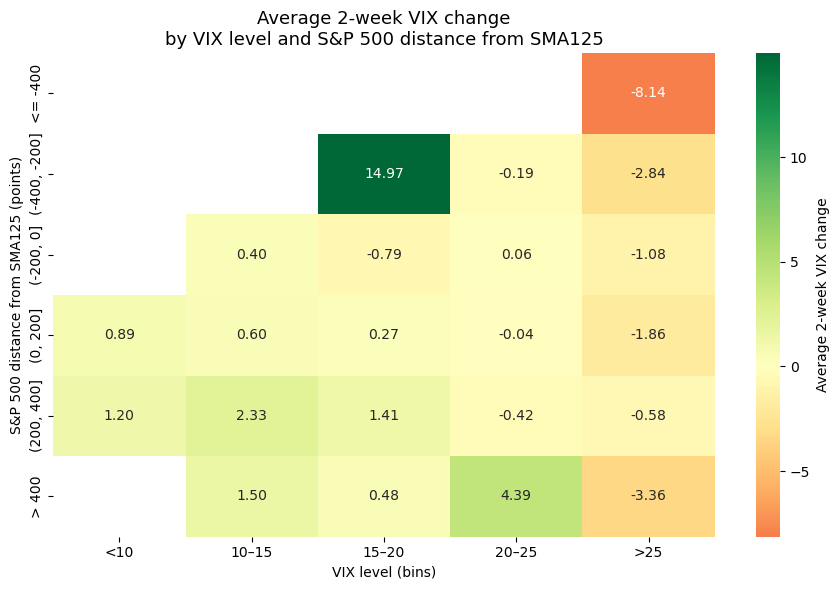

In [99]:
# Heatmap for average 14-day VIX change
heatmap_data_14d = grouped_vix_14d.pivot(
    index='Distance_bin',
    columns='VIX_bin',
    values='Avg_VIX_change_14d'
)

plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_data_14d,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    cbar_kws={'label': 'Average 2-week VIX change'}
)
plt.title("Average 2-week VIX change\nby VIX level and S&P 500 distance from SMA125", fontsize=13)
plt.xlabel("VIX level (bins)")
plt.ylabel("S&P 500 distance from SMA125 (points)")
plt.tight_layout()
plt.show()

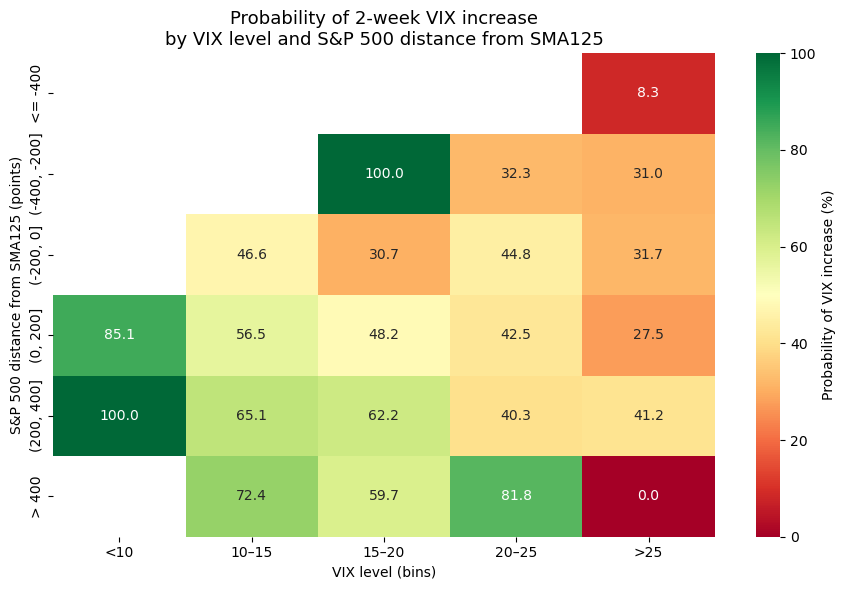

In [101]:
# Heatmap for probability of 14-day VIX increase
heatmap_up_14d = grouped_vix_14d.pivot(
    index='Distance_bin',
    columns='VIX_bin',
    values='Up_pct'
)

plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_up_14d,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    vmin=0, vmax=100,
    cbar_kws={'label': 'Probability of VIX increase (%)'}
)
plt.title("Probability of 2-week VIX increase\nby VIX level and S&P 500 distance from SMA125", fontsize=13)
plt.xlabel("VIX level (bins)")
plt.ylabel("S&P 500 distance from SMA125 (points)")
plt.tight_layout()
plt.show()

In [103]:
df['VIX_Change_next_day'] = df['VIX_Close'].shift(-1) - df['VIX_Close']

In [105]:
mask = df['VIX_Change_next_day'] >= 0.05 * df['VIX_Close']

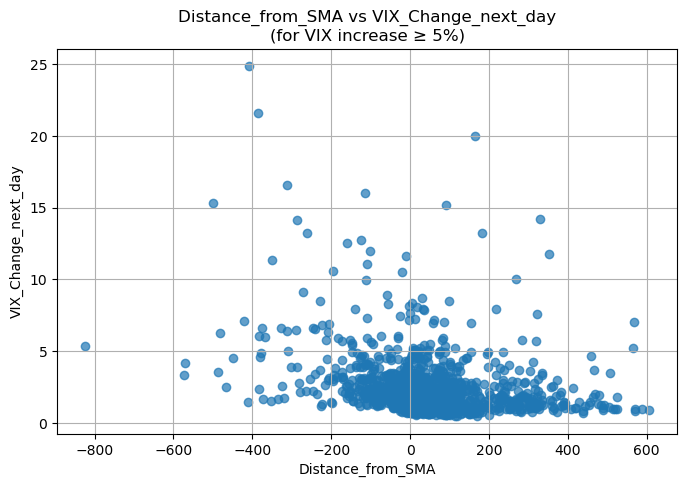

In [107]:
filtered_df = df[mask]

plt.figure(figsize=(8,5))
plt.scatter(filtered_df['Distance_from_SMA'], filtered_df['VIX_Change_next_day'], alpha=0.7)
plt.title('Distance_from_SMA vs VIX_Change_next_day\n(for VIX increase ≥ 5%)')
plt.xlabel('Distance_from_SMA')
plt.ylabel('VIX_Change_next_day')
plt.grid(True)
plt.show()

In [109]:
# Next-day VIX percentage change
df['VIX_Change_pct_next_day'] = (df['VIX_Close'].shift(-1) - df['VIX_Close']) / df['VIX_Close']

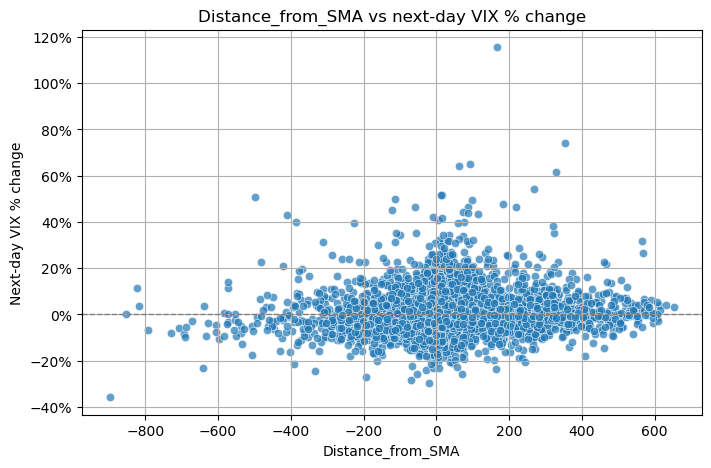

In [111]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x='Distance_from_SMA',
    y='VIX_Change_pct_next_day',
    alpha=0.7
)
plt.title('Distance_from_SMA vs next-day VIX % change')
plt.xlabel('Distance_from_SMA')
plt.ylabel('Next-day VIX % change')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

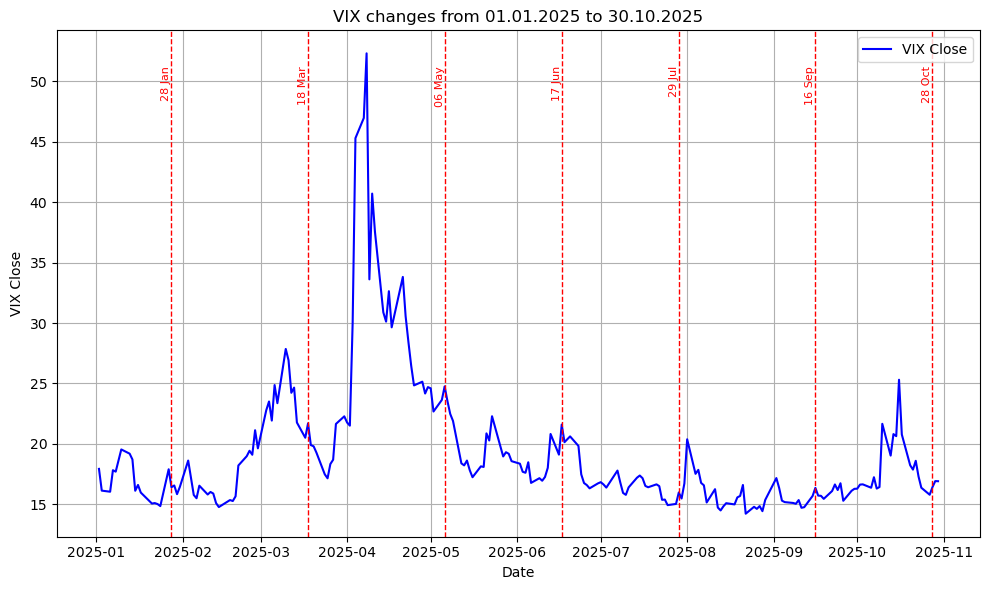

In [113]:
# VIX vs FED meetings
df['Date'] = pd.to_datetime(df['Date'])

mask = (df['Date'] >= '2025-01-01') & (df['Date'] <= '2025-10-30')
df_period = df.loc[mask]

fomc_dates = [
    '2025-01-28',
    '2025-03-18',
    '2025-05-06',
    '2025-06-17',
    '2025-07-29',
    '2025-09-16',
    '2025-10-28'
]
fomc_dates = pd.to_datetime(fomc_dates)

plt.figure(figsize=(10,6))
plt.plot(df_period['Date'], df_period['VIX_Close'], label='VIX Close', color='blue')
plt.title('VIX changes from 01.01.2025 to 30.10.2025')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.grid(True)

for date in fomc_dates:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)
    plt.text(date, df_period['VIX_Close'].max()*0.98, date.strftime('%d %b'), rotation=90, color='red',
             ha='right', va='top', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()